In [1]:
%matplotlib inline
import os
import json
import numpy as np
import pandas as pd
from scipy import stats
import pandas as pd
from ydata_profiling import ProfileReport
from image_processing_utils import extract_lens_features,load_metadata,convert_shutter_speed_to_numeric
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, chi2_contingency
import phik


In [2]:
# Define Meta data directory
metadata_directory = "C:\\Users\\ur4me\\Tests Image Dataset\\Metadata"

# Define the fields to extract
exif_fields = [
    "FileName",
    "ISO",
    "ShutterSpeedValue",
    "ApertureValue",
    "LensModel",
    "Flash",
    "ExposureCompensation",
]

# Loading metadata
metadata_list = load_metadata(metadata_directory)

# Initialise a list to hold all the EXIF data
exif_data_list = []

# Loop through EXIF files and extract the data
for exif_file in os.listdir(metadata_directory):
    if exif_file.endswith(".json"):
        with open(os.path.join(metadata_directory, exif_file), "r") as f:
            exif_data = json.load(f)
            # If the EXIF data is a list of dictionaries, take the first entry
            if isinstance(exif_data, list):
                exif_data = exif_data[0]
            # Extract the required fields
            selected_data = {field: exif_data.get(field) for field in exif_fields}
            exif_data_list.append(selected_data)

# Convert the list of EXIF data to a pandas DataFrame
df_exif = pd.DataFrame(exif_data_list)

In [3]:
# Apply the function to each row in the DataFrame
lens_features = df_exif.apply(extract_lens_features, axis=1)

# Combine the original DataFrame with the new lens features, excluding 'Series'
df_exif = pd.concat([df_exif, lens_features], axis=1)

# Apply the conversion function to the ShutterSpeedValue column
df_exif["ShutterSpeedValue"] = df_exif["ShutterSpeedValue"].apply(
    convert_shutter_speed_to_numeric
)
df_exif

,FileName,ISO,ShutterSpeedValue,ApertureValue,LensModel,Flash,ExposureCompensation,LensType,FocalLength,MaxAperture,Professional,Version,AutofocusType
0,00228E5E-5E88-496B-825B-05979735CF53.dng,500,0.004000,2.0,EF35mm f/1.4L II USM,"Off, Did not fire",0,EF,35,1.4,L,2,USM
1,003D7C10-B75B-4570-BA19-29AD2E1AE73C.dng,400,0.001563,1.6,EF85mm f/1.2L II USM,"Off, Did not fire",0,EF,85,1.2,L,2,USM
2,0100E25B-60C4-46DE-91C4-1655E3D3C052.dng,400,0.003125,2.0,EF35mm f/1.4L II USM,"Off, Did not fire",0,EF,35,1.4,L,2,USM
3,01319C38-DB6E-41B9-97DA-5F92B768A83F.dng,100,0.002500,2.0,EF35mm f/1.4L II USM,"Off, Did not fire",0,EF,35,1.4,L,2,USM
4,01347A25-98D6-4B21-A479-355F60A601E2.dng,4000,0.010000,1.6,EF35mm f/1.4L II USM,"Off, Did not fire",0,EF,35,1.4,L,2,USM
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,JAM23833.dng,200,0.004000,6.3,EF50mm f/1.2L USM,"Off, Did not fire",0,EF,50,1.2,L,0,USM
1490,JAM23834.dng,200,0.004000,6.3,EF50mm f/1.2L USM,"Off, Did not fire",0,EF,50,1.2,L,0,USM
1491,JAM23835.dng,200,0.004000,6.3,EF50mm f/1.2L USM,"Off, Did not fire",0,EF,50,1.2,L,0,USM
1492,JAM23836.dng,200,0.004000,6.3,EF50mm f/1.2L USM,"Off, Did not fire",0,EF,50,1.2,L,0,USM


In [4]:
histogram_directory = "C:\\Users\\ur4me\\Tests Image Dataset\\Histograms"  # Path where histogram JSON files are saved

# Prepare a list to hold data for all files
data_for_dataframe = []

# Loop through the JSON files in the histogram directory
for file in os.listdir(histogram_directory):
    if file.endswith("_histogram.json"):
        with open(os.path.join(histogram_directory, file), "r") as f:
            histogram_data = json.load(f)

            # Extract the base file name without the extension and convert to uppercase
            base_file_name = file.replace("_histogram.json", "").upper() + ".dng"

            # Flatten the histogram data for calculation
            hue_data = np.array(histogram_data["H"])
            sat_data = np.array(histogram_data["S"])
            val_data = np.array(histogram_data["V"])

            # Prepare the data entry with statistical features for each channel
            data_entry = {
                "FileName": base_file_name,
                # Calculate features for Hue
                "Hue_Mean": np.mean(histogram_data["H"]),
                "Hue_StdDev": np.std(histogram_data["H"]),
                "Hue_Skewness": stats.skew(histogram_data["H"]),
                "Hue_Kurtosis": stats.kurtosis(histogram_data["H"]),
                "Hue_Median": np.median(histogram_data["H"]),
                "Hue_25th_Percentile": np.percentile(histogram_data["H"], 25),
                "Hue_75th_Percentile": np.percentile(histogram_data["H"], 75),
                # Calculate features for Saturation
                "Saturation_Mean": np.mean(histogram_data["S"]),
                "Saturation_StdDev": np.std(histogram_data["S"]),
                "Saturation_Skewness": stats.skew(histogram_data["S"]),
                "Saturation_Kurtosis": stats.kurtosis(histogram_data["S"]),
                "Saturation_Median": np.median(histogram_data["S"]),
                "Saturation_25th_Percentile": np.percentile(histogram_data["S"], 25),
                "Saturation_75th_Percentile": np.percentile(histogram_data["S"], 75),
                # Calculate features for Value
                "Value_Mean": np.mean(histogram_data["V"]),
                "Value_StdDev": np.std(histogram_data["V"]),
                "Value_Skewness": stats.skew(histogram_data["V"]),
                "Value_Kurtosis": stats.kurtosis(histogram_data["V"]),
                "Value_Median": np.median(histogram_data["V"]),
                "Value_25th_Percentile": np.percentile(histogram_data["V"], 25),
                "Value_75th_Percentile": np.percentile(histogram_data["V"], 75),
            }

            # Append the data entry to our list
            data_for_dataframe.append(data_entry)

# Create a DataFrame from the list of data entries
hsv_dataframe = pd.DataFrame(data_for_dataframe)

In [5]:
# Combine the two dataset
merged_dataframe = pd.merge(df_exif, hsv_dataframe, on="FileName", how="inner")
merged_dataframe

,FileName,ISO,ShutterSpeedValue,ApertureValue,LensModel,Flash,ExposureCompensation,LensType,FocalLength,MaxAperture,...,Saturation_Median,Saturation_25th_Percentile,Saturation_75th_Percentile,Value_Mean,Value_StdDev,Value_Skewness,Value_Kurtosis,Value_Median,Value_25th_Percentile,Value_75th_Percentile
0,00228E5E-5E88-496B-825B-05979735CF53.dng,500,0.004000,2.0,EF35mm f/1.4L II USM,"Off, Did not fire",0,EF,35,1.4,...,71.5,12.00,215.00,171.0,271.631385,3.236444,10.565222,91.5,25.00,186.25
1,003D7C10-B75B-4570-BA19-29AD2E1AE73C.dng,400,0.001563,1.6,EF85mm f/1.2L II USM,"Off, Did not fire",0,EF,85,1.2,...,108.0,30.00,198.50,171.0,261.457737,3.375978,13.063794,86.0,30.00,207.50
2,0100E25B-60C4-46DE-91C4-1655E3D3C052.dng,400,0.003125,2.0,EF35mm f/1.4L II USM,"Off, Did not fire",0,EF,35,1.4,...,98.5,30.75,196.00,171.0,233.251340,3.152534,11.216643,132.5,32.00,187.00
3,01319C38-DB6E-41B9-97DA-5F92B768A83F.dng,100,0.002500,2.0,EF35mm f/1.4L II USM,"Off, Did not fire",0,EF,35,1.4,...,118.5,7.00,265.50,171.0,140.368989,1.450798,3.663195,137.0,78.25,237.50
4,01347A25-98D6-4B21-A479-355F60A601E2.dng,4000,0.010000,1.6,EF35mm f/1.4L II USM,"Off, Did not fire",0,EF,35,1.4,...,122.0,48.00,181.00,171.0,242.411550,3.398189,12.028492,93.0,64.00,145.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1489,JAM23833.dng,200,0.004000,6.3,EF50mm f/1.2L USM,"Off, Did not fire",0,EF,50,1.2,...,1792.0,232.50,4043.75,2732.0,1774.247279,0.724535,-0.056286,2534.5,1240.25,3799.50
1490,JAM23834.dng,200,0.004000,6.3,EF50mm f/1.2L USM,"Off, Did not fire",0,EF,50,1.2,...,1708.5,264.50,4050.00,2732.0,1796.556476,0.786667,0.071825,2489.0,1249.25,3846.00
1491,JAM23835.dng,200,0.004000,6.3,EF50mm f/1.2L USM,"Off, Did not fire",0,EF,50,1.2,...,1716.0,228.50,3998.75,2732.0,1706.073606,0.838297,0.210788,2431.5,1405.50,3710.00
1492,JAM23836.dng,200,0.004000,6.3,EF50mm f/1.2L USM,"Off, Did not fire",0,EF,50,1.2,...,1660.5,225.75,4083.00,2732.0,1761.474150,0.814084,0.122968,2496.5,1299.25,3761.75


## Exploratory Data Analysis

In [6]:
# Prepare for EDA
df_eda = merged_dataframe.drop(columns=["FileName", "LensModel"])

In [7]:
# Profiling Report
profile = ProfileReport(df_eda, minimal=True)
# profile = ProfileReport(df_eda)
profile.to_notebook_iframe()
# To see output from Github, visit https://nbviewer.org/github/ur4me/PhotoMetrics-Correlation-Analysis/blob/master/step4.ipynb

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
merged_dataframe.describe()

,ISO,ShutterSpeedValue,ApertureValue,FocalLength,MaxAperture,Version,Hue_Mean,Hue_StdDev,Hue_Skewness,Hue_Kurtosis,...,Saturation_Median,Saturation_25th_Percentile,Saturation_75th_Percentile,Value_Mean,Value_StdDev,Value_Skewness,Value_Kurtosis,Value_Median,Value_25th_Percentile,Value_75th_Percentile
count,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,...,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000
mean,406.338688,0.009296,4.253012,44.384203,1.316332,0.795181,1358.933735,4284.136791,6.217028,53.318126,...,694.794511,152.029116,1414.202477,1358.933735,2576.954531,4.342178,35.580654,559.489290,172.663989,1721.536814
std,716.154903,0.026082,2.304249,10.043891,0.161169,0.979128,1277.577490,4253.207031,2.447552,43.164110,...,740.626744,167.107570,1382.626734,1277.577490,3113.018168,3.139612,45.987505,562.011041,212.089147,1711.991701
min,100.000000,0.000125,1.200000,24.000000,1.200000,0.000000,171.000000,212.351032,2.012812,4.011113,...,0.000000,0.000000,0.000000,171.000000,43.892269,-0.398145,-1.605494,0.000000,0.000000,19.250000
25%,200.000000,0.003125,2.000000,35.000000,1.200000,0.000000,171.000000,474.624611,4.572804,24.930209,...,76.125000,17.750000,201.437500,171.000000,194.681423,1.968418,4.579778,102.125000,42.375000,205.250000
50%,200.000000,0.004000,4.500000,50.000000,1.200000,0.000000,171.000000,722.201394,5.556651,38.547114,...,138.250000,67.000000,282.625000,171.000000,384.945448,3.537064,17.687867,157.500000,89.125000,289.375000
75%,400.000000,0.004000,6.300000,50.000000,1.400000,2.000000,2732.000000,8057.337552,7.187574,62.440764,...,1451.250000,270.937500,2687.500000,2732.000000,4481.602400,5.780652,46.729146,1065.750000,240.750000,3529.187500
max,8000.000000,0.166667,10.000000,85.000000,1.800000,2.000000,2732.000000,16204.924189,14.318226,216.319126,...,2774.500000,1188.000000,4746.000000,2732.000000,18499.043568,15.699138,246.603840,2878.500000,1678.750000,5423.250000


## Correlation Analysis

In [9]:
# Get a list of categorical variables
df_corr = merged_dataframe.drop(columns=["FileName", "LensModel"])
df_corr.to_csv("df_corr.csv", index=False)
categorical_columns = df_corr.select_dtypes(
    include=["object", "category"]
).columns.tolist()
print("Categorical variables:")
print(categorical_columns)

Categorical variables:
['Flash', 'ExposureCompensation', 'LensType', 'Professional', 'AutofocusType']


interval columns not set, guessing: ['ISO', 'ShutterSpeedValue', 'ApertureValue', 'FocalLength', 'MaxAperture', 'Version', 'Hue_Mean', 'Hue_StdDev', 'Hue_Skewness', 'Hue_Kurtosis', 'Hue_Median', 'Hue_25th_Percentile', 'Hue_75th_Percentile', 'Saturation_Mean', 'Saturation_StdDev', 'Saturation_Skewness', 'Saturation_Kurtosis', 'Saturation_Median', 'Saturation_25th_Percentile', 'Saturation_75th_Percentile', 'Value_Mean', 'Value_StdDev', 'Value_Skewness', 'Value_Kurtosis', 'Value_Median', 'Value_25th_Percentile', 'Value_75th_Percentile']


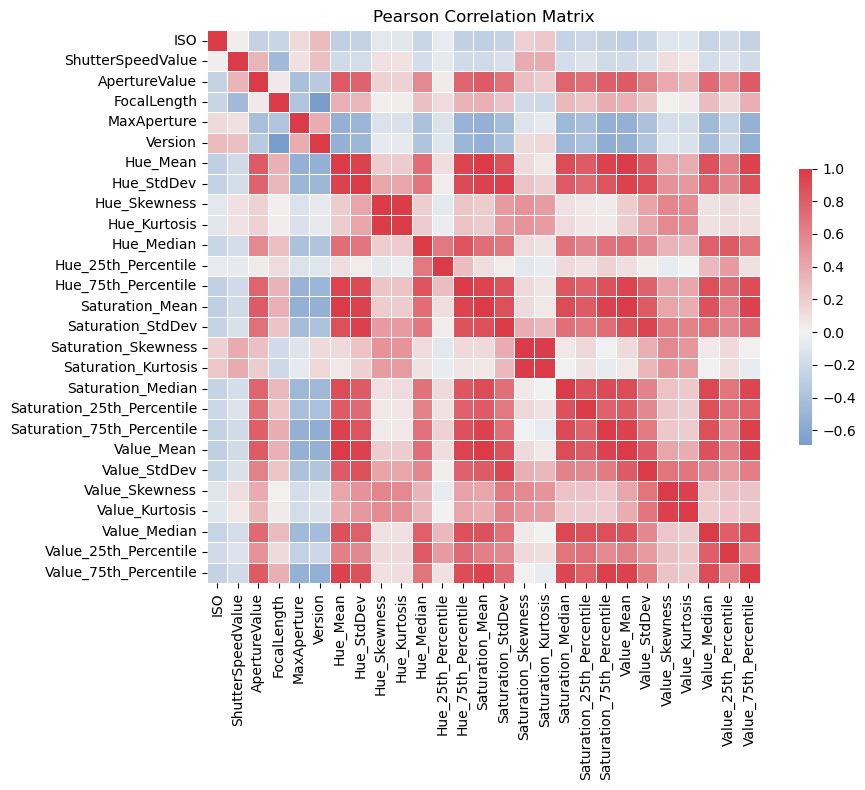

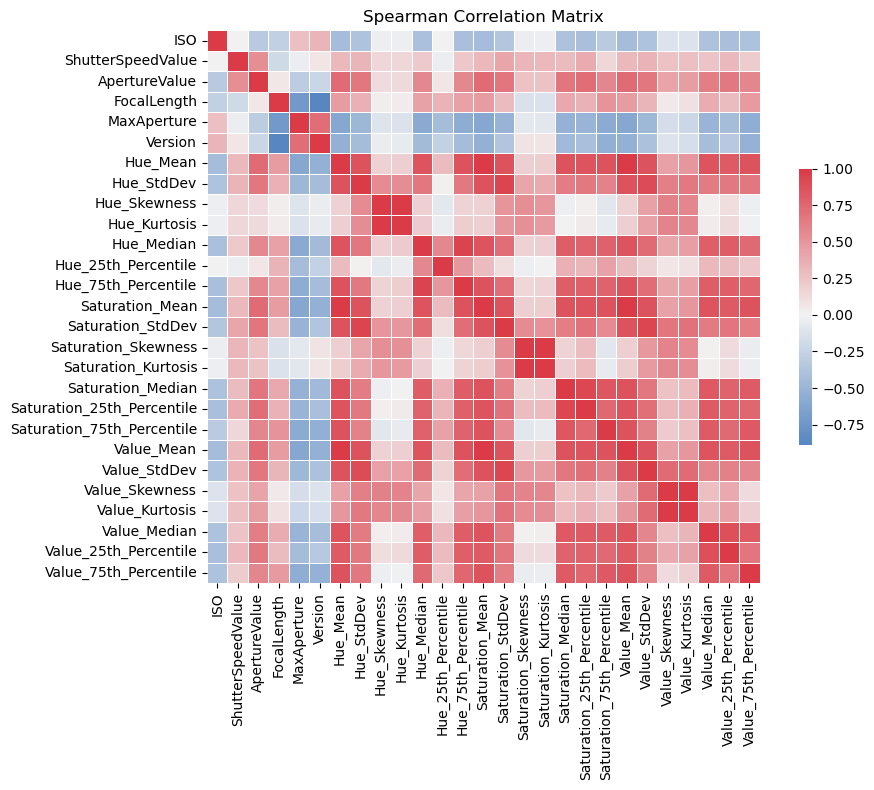

interval columns not set, guessing: ['ISO', 'ShutterSpeedValue', 'ApertureValue', 'FocalLength', 'MaxAperture', 'Version', 'Hue_Mean', 'Hue_StdDev', 'Hue_Skewness', 'Hue_Kurtosis', 'Hue_Median', 'Hue_25th_Percentile', 'Hue_75th_Percentile', 'Saturation_Mean', 'Saturation_StdDev', 'Saturation_Skewness', 'Saturation_Kurtosis', 'Saturation_Median', 'Saturation_25th_Percentile', 'Saturation_75th_Percentile', 'Value_Mean', 'Value_StdDev', 'Value_Skewness', 'Value_Kurtosis', 'Value_Median', 'Value_25th_Percentile', 'Value_75th_Percentile']


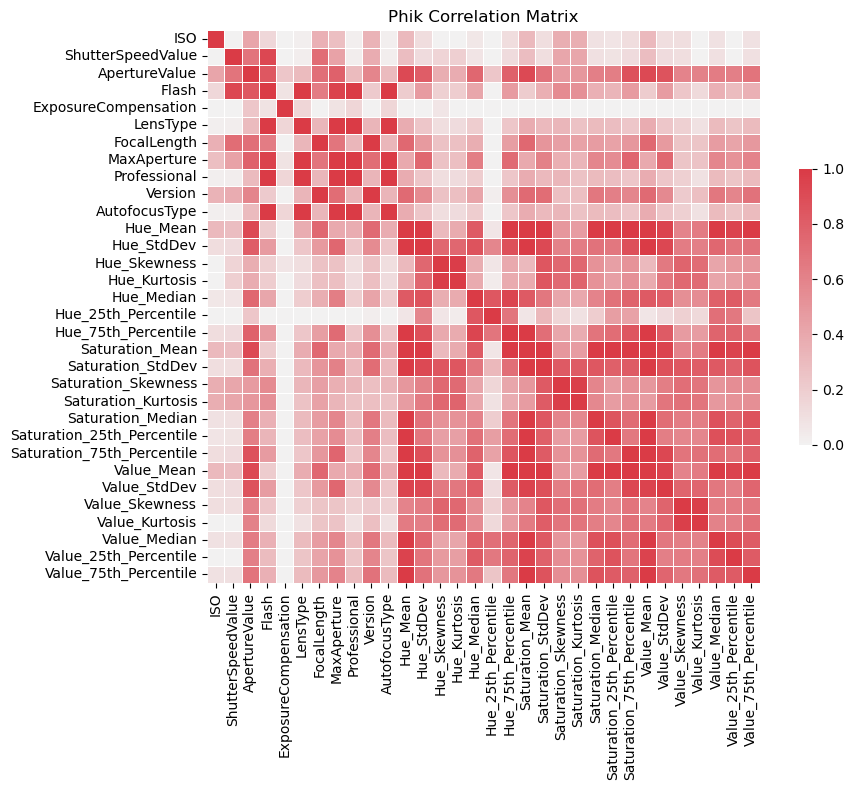

In [10]:
# Calculate Pearson correlation for numerical variables
pearson_corr = df_corr.select_dtypes(include=[np.number]).corr(method="pearson")

# Calculate Spearman correlation for non-linear relationships
spearman_corr = df_corr.select_dtypes(include=[np.number]).corr(method="spearman")

# Phik correlation for mixed data types (numeric and categorical) : Based on Chi-squared Test
phik_corr = df_corr.phik_matrix()

# Define the colormap
cmap = sns.diverging_palette(250, 10, as_cmap=True)

# Visualize the Pearson correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    pearson_corr,
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
plt.title("Pearson Correlation Matrix")
plt.tight_layout()
plt.show()

# Visualize the Spearman correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(
    spearman_corr,
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
plt.title("Spearman Correlation Matrix")
plt.tight_layout()
plt.show()

# Visualize the Phik correlation matrix
phik_corr = df_corr.phik_matrix()
plt.figure(figsize=(10, 8))
sns.heatmap(
    phik_corr,
    cmap=cmap,
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.5},
)
plt.title("Phik Correlation Matrix")
plt.tight_layout()
plt.show()